11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch   1/600 – G_loss 0.6585  D_loss 1.3586
Epoch   2/600 – G_loss 0.6311  D_loss 1.3116
Epoch   3/600 – G_loss 0.5989  D_loss 1.3034
Epoch   4/600 – G_loss 0.5788  D_loss 1.2988
Epoch   5/600 – G_loss 0.5768  D_loss 1.2931
Epoch   6/600 – G_loss 0.5827  D_loss 1.2917
Epoch   7/600 – G_loss 0.5860  D_loss 1.3028
Epoch   8/600 – G_loss 0.5873  D_loss 1.3255
Epoch   9/600 – G_loss 0.5970  D_loss 1.3411
Epoch  10/600 – G_loss 0.6163  D_loss 1.3451
Epoch  11/600 – G_loss 0.6379  D_loss 1.3468
Epoch  12/600 – G_loss 0.6610  D_loss 1.3496
Epoch  13/600 – G_loss 0.6855  D_loss 1.3497
Epoch  14/600 – G_loss 0.7080  D_loss 1.3473
Epoch  15/600 – G_loss 0.7223  D_loss 1.3512
Epoch  16/600 – G_loss 0.7287  D_loss 1.3594
Epoch  17/600 – G_loss 0.7302  D_loss 1.3674
Epoch  18/600 – G_loss 0.7291  D_loss 1.3725
Epoch  19/600 – G_loss 0.7300  D_loss 1.3715
Epoch  20/600 – G_loss 0.7339  D_loss 1.3675
Epoch  21/600 – G_loss 0.7413  D_loss 1.3622
Epoch  22/600 – G_loss 0.7501  D_loss 1.3565
Epoch  23/

Epoch 600/600 – G_loss 0.8936  D_loss 1.3112
Generator saved to fcgan_generator.h5
Images written to gen_samples/


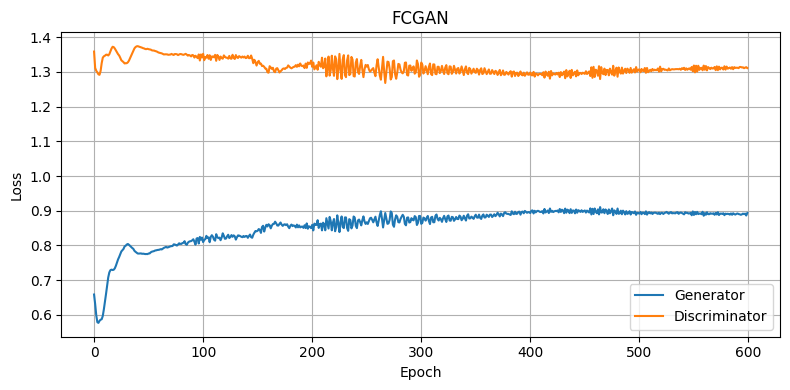

In [ ]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import layers

# Mixed Precision
tf.config.optimizer.set_jit(True)           # XLA
set_global_policy("mixed_float16")          # FP16 where safe

# Optional: make TF log less chatty
tf.get_logger().setLevel("ERROR")

# Data
(train_images, _), _ = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5        # [-1, 1]

BUFFER_SIZE = 60_000
BATCH_SIZE  = 4096  # big batch
train_ds = (tf.data.Dataset.from_tensor_slices(train_images)
            .cache()                                  # stays in RAM
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE, drop_remainder=True)   # constant size
            .prefetch(tf.data.AUTOTUNE))

# 2. Model
LATENT_DIM = 100

def make_generator():
    return tf.keras.Sequential([
        layers.Input(shape=(1, 1, LATENT_DIM)),
        layers.Conv2DTranspose(192, 7, strides=1, padding="valid"),  # 256→192
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, 4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, 4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, 3, strides=1, padding="same",
                               activation="tanh", dtype="float32"),  # final FP32
    ], name="fcgan_generator")

def make_discriminator():
    return tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, 4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(1, 7, strides=1, padding="valid", dtype="float32"),  # logits in FP32
        layers.Activation("sigmoid", dtype="float32"),
    ], name="fcgan_discriminator")

generator     = make_generator()
discriminator = make_discriminator()

# 3. Loss & Optims
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gen_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def disc_loss(real_out, fake_out):
    real_labels = tf.ones_like(real_out) * 0.9
    fake_labels = tf.zeros_like(fake_out)
    return bce(real_labels, real_out) + bce(fake_labels, fake_out)

g_opt = tf.keras.optimizers.Adam(2.5e-5, 0.5)  # keep master weights in FP32
d_opt = tf.keras.optimizers.Adam(2.5e-5, 0.5)

# 4. Train Step
@tf.function(jit_compile=True)           # extra hint for XLA
def train_step(real_imgs):
    noise = tf.random.normal([BATCH_SIZE, 1, 1, LATENT_DIM])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_imgs = generator(noise, training=True)
        real_out  = discriminator(real_imgs, training=True)
        fake_out  = discriminator(fake_imgs, training=True)

        g_loss = gen_loss(fake_out)
        d_loss = disc_loss(real_out, fake_out)

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    return g_loss, d_loss

# 5. Helper ‑ Images
import matplotlib.pyplot as plt, numpy as np, imageio, pathlib, os

def save_grid(images, path, cols=5):
    imgs = (images + 1) / 2.0
    rows = (len(imgs) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    for i, img in enumerate(imgs):
        axes[i].imshow(img[:, :, 0], cmap="gray")
        axes[i].axis("off")
    for ax in axes[len(imgs):]:
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()

def generate_and_save(generator, num_samples=25, out_dir="gen_samples"):
    pathlib.Path(out_dir).mkdir(exist_ok=True)
    noise = tf.random.normal([num_samples, 1, 1, LATENT_DIM])
    gen   = generator(noise, training=False)
    gen   = (gen + 1) / 2.0

    for i, img in enumerate(gen):
        img_u8 = tf.image.convert_image_dtype(img, tf.uint8)
        imageio.imwrite(f"{out_dir}/digit_{i:04d}.png", img_u8.numpy().squeeze())

    save_grid(gen.numpy(), f"{out_dir}/grid.png")

# 6. Training Loop
EPOCHS = 600
g_losses, d_losses = [], []

for epoch in range(EPOCHS):
    g_tot = d_tot = batches = 0
    for batch in train_ds:
        g_loss, d_loss = train_step(batch)
        g_tot += g_loss
        d_tot += d_loss
        batches += 1

    g_losses.append(g_tot / batches)
    d_losses.append(d_tot / batches)
    print(f"Epoch {epoch+1:3d}/{EPOCHS} – "
          f"G_loss {g_losses[-1]:6.4f}  D_loss {d_losses[-1]:6.4f}")

# 7. Post‑Training
generator.save("fcgan_generator.h5")
print("Generator saved to fcgan_generator.h5")

generate_and_save(generator, num_samples=25)
print("Images written to gen_samples/")

# Loss curves (quick sanity)
plt.figure(figsize=(8,4))
plt.plot(g_losses, label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("FCGAN")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


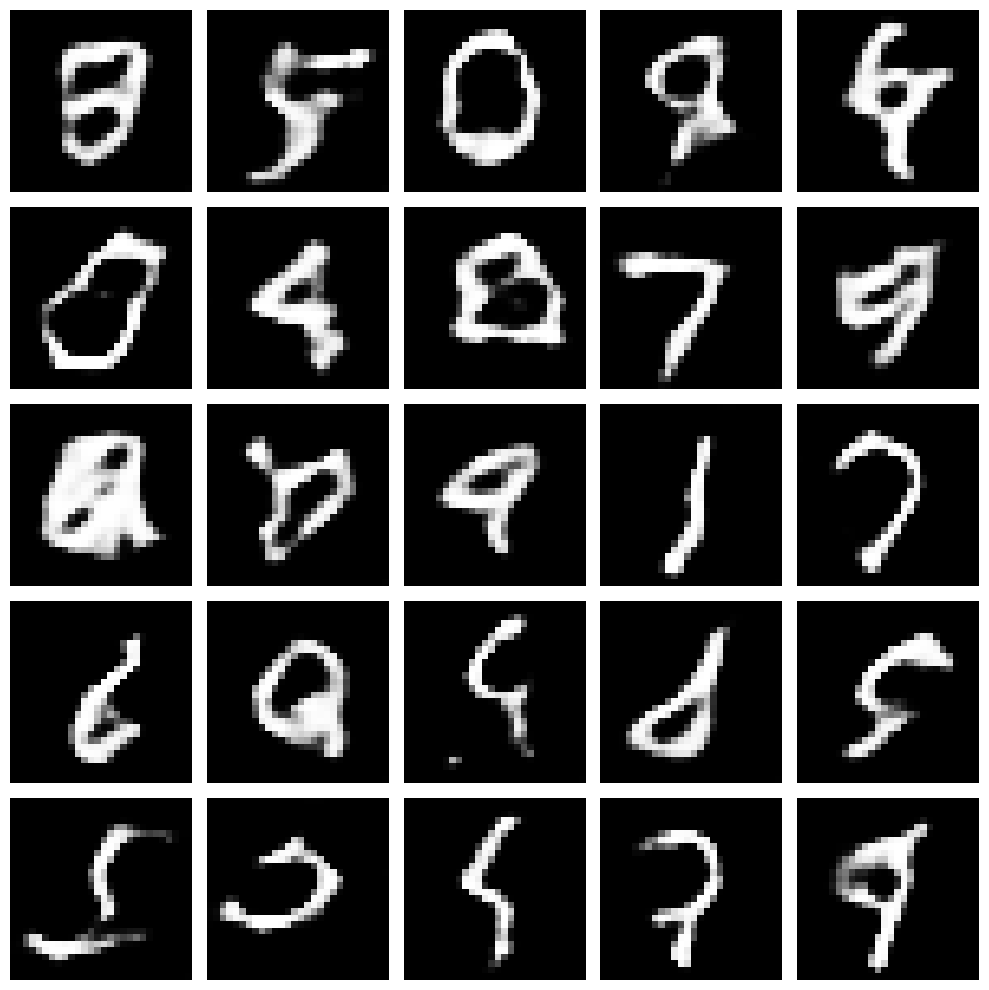

In [ ]:
# 8. Quick Preview

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

LATENT_DIM = 100
N_SHOW     = 25           # Number of images to display
COLS       = 5            # grid columns

def sample_and_show(gen_model, n=N_SHOW, cols=COLS):
    """Draw `n` fresh digits with `gen_model` and show them in a grid."""
    noise = tf.random.normal([n, 1, 1, LATENT_DIM])
    imgs  = gen_model(noise, training=False)
    imgs  = (imgs + 1) / 2.0        # → [0,1] float32

    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(imgs[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# 1) If you just finished training, `generator` is already in memory:
sample_and_show(generator)

# 2) If you’re in a fresh session, first reload the saved model:
# generator = tf.keras.models.load_model("fcgan_generator.h5", compile=False)
# sample_and_show(generator)


In [ ]:
# ----- Parameters you might tweak -----
NUM_IMAGES = 5000 #No. of images to generate
LATENT_DIM = 100  #must match training
FAKE_DIR   = "gen_samples_eval"

# --------------------------------------
import tensorflow as tf, os, imageio
import numpy as np
from tqdm import tqdm

os.makedirs(FAKE_DIR, exist_ok=True)

# 1. Reload the trained generator (saved by the previous script)
generator = tf.keras.models.load_model("fcgan_generator.h5", compile=False)

# 2. Generate and save NUM_IMAGES PNGs
for i in tqdm(range(NUM_IMAGES), desc="Generating digits"):
    noise = tf.random.normal([1, 1, 1, LATENT_DIM])
    img   = generator(noise, training=False)       # shape (1,28,28,1), range [-1,1]
    img   = (img + 1) / 2.0                        # → [0,1] float32
    png   = tf.image.convert_image_dtype(img[0], tf.uint8)
    imageio.imwrite(f"{FAKE_DIR}/digit_{i:05d}.png", png.numpy().squeeze())

print(f"{NUM_IMAGES} images saved to {FAKE_DIR}/")


Generating digits: 100%|██████████| 5000/5000 [01:23<00:00, 60.11it/s]

5000 images saved to gen_samples_eval/


In [ ]:
REAL_DIR = "real_images_eval"
os.makedirs(REAL_DIR, exist_ok=True)

# Make sure `train_images` (scaled to [-1,1]) is still in memory; if not, reload MNIST:
try:
    train_images
except NameError:
    (train_images, _), _ = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(-1, 28, 28, 1).astype("float32")
    train_images = (train_images - 127.5) / 127.5

# Save the first `NUM_IMAGES` samples
for i, img in enumerate(train_images[:NUM_IMAGES]):
    png = ((img + 1) / 2.0 * 255).astype(np.uint8).squeeze()
    imageio.imwrite(f"{REAL_DIR}/digit_{i:05d}.png", png)

print(f"{NUM_IMAGES} real images saved to {REAL_DIR}/")


5000 real images saved to real_images_eval/


In [ ]:
!clean-fid compute-fid --real-path /content/real_images_eval --fake-path gen_samples_eval
!pip install clean-fid
from cleanfid import fid

fid_score = fid.compute_fid("/content/real_images_eval", "/content/gen_samples_eval")

print(f"FID = {fid_score:.2f}")


/bin/bash: line 1: clean-fid: command not found


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 5000 images in the folder /content/real_images_eval


FID real_images_eval : 100%|██████████| 157/157 [00:30<00:00,  5.17it/s]


Found 5000 images in the folder /content/gen_samples_eval


FID gen_samples_eval : 100%|██████████| 157/157 [00:32<00:00,  4.83it/s]


FID = 38.28
